#### Proceso de scraping

En primer lugar comenzamos definiendo el objeto reddit, y realizamos una serie de pruebas para empezar a scrappear la informacion de reddit.

In [19]:
from time import sleep

In [20]:
%pip install praw

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\MAM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
import praw

# Configura tu conexión con Reddit
reddit = praw.Reddit(
    client_id="XEVqTpGA9HE6MNujQAWt1w",
    client_secret="bv4J3usOH-V__I4tGD__bLoWnGA_Sg",
    user_agent="Testing_api",
    read_only=True
)



Buscamos en el subreddit de 'flat earth' y vemos los resultados.


In [22]:
# Define el subreddit y la búsqueda
subreddit_name = "flatearth"

queries_list = [
    "flat earth",
]

resultados_totales = set()

subredit = reddit.subreddit(subreddit_name)

# Realiza la búsqueda en el subreddit
for query in queries_list:
    print(f"Buscando en el subreddit {subreddit_name} con la consulta '{query}'")
    resultados = subredit.search(query, limit=100)
    
    # Itera sobre los resultados
    for submission in resultados:
        # Verifica si el título ya está en los resultados totales
        if submission.title not in resultados_totales:
            resultados_totales.add(submission)

Buscando en el subreddit flatearth con la consulta 'flat earth'


Una vez realizamos la consulta, vemos la información que tenemos de cada post para ver cómo relacionar los nodos y estructurar el grafo.

In [23]:
#Tomamos el primer post de los resultados

post = list(resultados_totales)[0]

In [24]:
# Extraer el título y el contenido del post asi como el nombre del autor

print(f"Title: {post.title}")
print(f"Author: {post.author}")
print(f"Content: {post.selftext}")
print(f"URL: {post.url}")
print(f"Upvotes: {post.ups}")
print(f"Downvotes: {post.downs}")
print(f"Comments: {post.num_comments}")
print(f"Created: {post.created}")
print(f"Subreddit: {post.subreddit}")
print(f"Post ID: {post.id}")
print(f"Post URL: {post.url}")
print(f"Post Score: {post.score}")

print('\n\n')

#Navegar el arbol de comentarios
comentarios = post.comments

comentario = comentarios[0]
print(f"Comentario: {comentario.body}")
print(f"Autor: {comentario.author}")
print(f"Upvotes: {comentario.ups}")
print(f"Downvotes: {comentario.downs}")
print(f"Created: {comentario.created}")
print(f"Comentario ID: {comentario.id}")
print(f"Comentario URL: {comentario.permalink}")
print(f"Comentario Score: {comentario.score}")

Title: I went to the UK flat earth convention
Author: cooolest
Content: I had an amazing time. I met a lot of lovely people who I'm sure would be good friends if I were to meet with them regularly.

Everyone was weird in their own way, but only as weird as the average person is. When talking with someone about my personal life and other ordinary topics, there was no way to tell if I was speaking with a flattie or a globie.

When conversations moved to conspiracies and government however, it was clear that I was speaking with someone with strong opinions. 

I met many people against vaccines, many people who did not believe in planets, and even had someone explain to me how there was little evidence of gas chambers in Nazi concentration camps. Everyone was in agreement that NASA was not to be trusted.

I attended some very fascinating talks from people who seemed seriously deluded. One speaker explained how he had connected the dots to show that not only is our earth flat, but we live o

### Extracción de publicaciones y comentarios desde la API de Reddit

Al consultar la API obtenemos, en un solo lote, toda la información de cada publicación y de sus comentarios: incluso los “hilos” anidados aparecen aplanados en una lista única, lo que facilita procesarlos sin navegar por una estructura de árbol.

---

#### Limitaciones y retos

1. **Máximo de 100 publicaciones por consulta**  
   La API solo devuelve hasta 100 posts en cada llamada. Si necesitamos más, debemos encadenar varias consultas y combinar sus resultados manualmente.

2. **Límite de peticiones por segundo**  
   Reddit restringe la frecuencia de llamadas: demasiadas peticiones en corto tiempo pueden provocar bloqueos temporales. Es imprescindible espaciar las consultas (por ejemplo, con `time.sleep()`) o gestionar un backoff automático.

3. **Posibles duplicados**  
   Al hacer varias consultas (por fecha, por palabra clave, etc.), podemos recuperar el mismo post varias veces. Hay que implementar un filtro que descarte identificadores repetidos.

4. **Ruido y contenido irrelevante**  
   Memes, publicaciones bromistas o comentarios sin sustancia pueden contaminar el análisis. Para centrarnos en usuarios realmente convencidos, es útil definir términos clave o patrones de búsqueda que apunten a debates serios.

---

#### Estrategia sugerida

Una manera eficaz de sortear estas limitaciones es:

1. **Definir una lista de palabras clave**  
   Representativas del tema (p. ej. “terrabrain”, “climate hoax”, “antivax”).

2. **Ejecutar una consulta por cada término**  
   Recuperando hasta 100 posts en cada ronda.

3. **Unir todos los resultados**  
   En una sola colección, eliminando duplicados por ID.

4. **Aplicar un pequeño retardo**  
   Entre peticiones para respetar el límite de la API.

5. **Filtrar el contenido final**  
   - Buscar solo publicaciones que contengan varias de esas palabras clave.  
   - O bien establecer un umbral mínimo de upvotes, para quedarnos con interacciones de mayor relevancia.

De este modo, ampliamos la cobertura más allá de 100 posts, reducimos el ruido y evitamos bloqueos por exceso de llamadas.


In [25]:
%pip install networkx matplotlib.pyplot tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\MAM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for matplotlib.pyplot


In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


#### Definición de funciones para extraer datos de Reddit y construir el grafo

Vamos a definir una serie de funciones que nos permitan:

1. Recuperar la información relevante desde la API de Reddit (publicaciones, comentarios, autores, etc.).  
2. Procesar esos datos para identificar entidades (usuarios, subreddits) y sus relaciones.  
3. Almacenar todo en un grafo utilizando la librería **networkx**, donde cada nodo representará un usuario o un subreddit y cada arista reflejará una interacción.

In [27]:
def get_results(subreddit, query_list, n_post = 10):
    resultados_totales = set()
    
    subredit = reddit.subreddit(subreddit)
    
    for query in query_list:
        print(f"Buscando en el subreddit {subreddit} con la consulta '{query}'")
        
        try:
        
            resultados = subredit.search(query, limit=n_post)
            
            for submission in resultados:
                # Verifica si el título ya está en los resultados totales
                if submission.title not in resultados_totales:
                    resultados_totales.add(submission)
                    
        except Exception:
            continue
                
    return resultados_totales


##### Función `scrapear_subreddit`

Esta función extrae información de un subreddit y la convierte en un grafo de interacciones entre usuarios y el propio subreddit.

1. **Obtener posts**  
   Llama a `get_results(subreddit, query_list, n_post)` para recuperar hasta `n_post` publicaciones que coincidan con las palabras clave de `query_list`.

2. **Crear nodo de subreddit**  
   Añade el nombre del subreddit como **nodo raíz** en el grafo.

3. **Procesar cada publicación**  
   Para cada `post` obtenido:
   - Si existe autor, lo añade como nodo y crea una arista entre el subreddit y el autor.
   - Descarga **todos** los comentarios (gestionando posibles errores de rate limit).
   - Ordena los comentarios por `score` (de mayor a menor).
   - Si se especifica `max_comments`, recorta la lista a ese número.

4. **Construir conexiones entre usuarios**  
   Para cada comentario seleccionado:
   - Añade al autor del comentario como nodo (si no estaba).
   - Crea una arista **directa** entre el autor del post y el autor del comentario (sin duplicados).

---

**Resumen:**  
`scapear_subreddit` construye un grafo donde:
- **Nodos** = subreddits y usuarios.  
- **Aristas** = interacción (quién publica en qué subreddit, quién comenta los posts de quién).  
Esto permite visualizar y analizar la red de conversaciones dentro de un subreddit.  

In [28]:
def scrapear_subreddit(subreddit, query_list, n_post = 10, max_comments = None):
    
    # Obtener los resultados
    resultados_totales = get_results(subreddit, query_list, n_post)

    # Agregar nodo raíz al grafo
    grafo.add_node(subreddit)
    
    # Agregar los nodos y aristas al grafo
    for post in tqdm(list(resultados_totales)):
        if post.author:
            grafo.add_node(post.author.name,subreddit=subreddit)
            grafo.add_edge(subreddit, post.author.name)
            
        while True:
            try:
                post.comments.replace_more(limit=None)
                break
            except Exception:
                print('demasiadas peticiones')
                sleep(10)
            
        comentarios = sorted(post.comments.list(), key=lambda x: x.score, reverse=True)
        
        for comentario in comentarios:
            if comentario.author:
                #comprueba que el nodo ya existe
                if grafo.has_node(comentario.author.name):
                    if not grafo.has_edge(post.author.name, comentario.author.name):
                        grafo.add_edge(post.author.name, comentario.author.name)
                        
        if max_comments is not None:
            comentarios = comentarios[:max_comments]
        
        for comentario in comentarios:
            if comentario.author:
                grafo.add_node(comentario.author.name, subreddit=subreddit)
                #comprobar que no exista ya la arista
                if not grafo.has_edge(post.author.name, comentario.author.name):
                    grafo.add_edge(post.author.name, comentario.author.name)

De esta forma podemos tomar información de un subreddit en función de las palabras clave de la lista, guardándolas en un grafo después.

In [29]:
# Probamos entonces nuestra funcion de scrapping.
grafo = nx.Graph()

scrapear_subreddit('flatearth', ['flatearth'], n_post = 10)
scrapear_subreddit('antivaccine', ['antivaccine'], n_post = 10)


Buscando en el subreddit flatearth con la consulta 'flatearth'


100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


Buscando en el subreddit antivaccine con la consulta 'antivaccine'


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Numero de nodos: 1552
Numero de aristas: 1658
Numero de componentes: 2
Promedio de grado: 2.13659793814433
Promedio de clustering: 7.308507434230341e-05


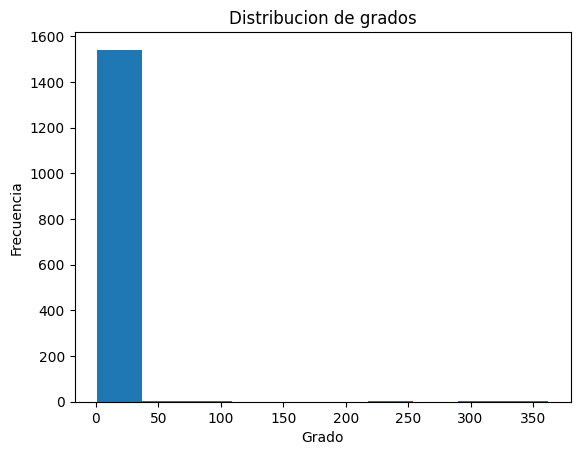

In [30]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

# Y un histograma de la distribucion de grados

plt.hist([grafo.degree(nodo) for nodo in grafo.nodes()])
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.title('Distribucion de grados')
plt.show()


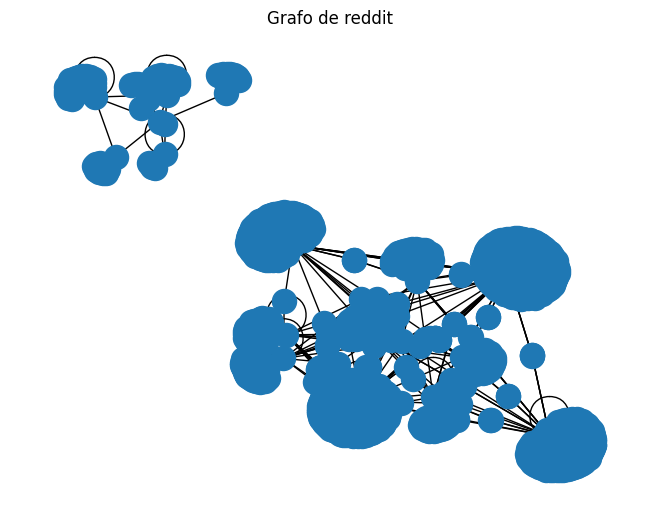

In [31]:
# Vamos a ver el grafo

nx.draw(grafo)
plt.title('Grafo de reddit')
plt.show()

In [32]:
#exporta el grafo a un archivo GML

nx.write_gml(grafo, "grafo.gml")

#### Preparando las queries para el grafo definitivo.

Buscamos los subreddit que nos puedan ayudar a resolver nuestra hipótesis, además de palabras clave que diferencien a los usuarios creyentes de los que no lo son. Utilizaremos algunas comunes y otras específicas del tema para afinar mejor.

Abarcamos desde creencias más inofensivas como la de la existencia de aliens o la tierra plana hasta otras más controvertidas y peligrosas como la de las vacunas.

In [33]:
lista_comunes = ["critical thinking", "question everything", "pseudoscience",  "debunk", "denial", "conspiracy"]

subreddit_keywords = {
    'FlatEarth': [
        'flat earth theory',
        'ice wall discovery',
        'antarctic cover‑up',
        'horizon anomaly',
        'ground is level',
        *lista_comunes
    ],
    'moonlandinghoax': [
        'fake lunar mission',
        'studio filmed moon',
        'camera glitch proof',
        'lunar module lies',
        'NASA backlot conspiracy',
        *lista_comunes
    ],
    'aliens': [
        'ufo disclosure',
        'area 51 secrets',
        'extraterrestrial visit',
        'crop circle proof',
        'alien cover‑up',
        *lista_comunes
    ],
    'No5G': [
        '5g health risks',
        'radiation cover‑up',
        'cell tower danger',
        'electromagnetic fraud',
        'hidden toxicity',
        *lista_comunes
    ],
    'chemtrails': [
        'chemical spraying',
        'aerosol cover‑up',
        'geoengineering proof',
        'toxics in sky',
        'secret air program',
        *lista_comunes
    ],
    'antiVaxx': [
        'big pharma lies',
        'vaccine injury cover‑up',
        'unreported side effects',
        'injection fraud',
        'medical experimentation',
        *lista_comunes
    ],
    'pesticideconspiracy': [
        'pesticide runoff cover‑up',
        'agrochemical conspiracy',
        'glyphosate danger',
        'farmers whistleblower',
        'toxic crop spraying',
        *lista_comunes
    ],
    'CovidConspiracy': [
        'plandemic proof',
        'virus lab leak cover‑up',
        'mask mandate fraud',
        'PCR gate',
        'vaccine passport tyranny',
        *lista_comunes
    ],
    'climatechangeisalie': [
        'co2 myth',
        'green agenda',
        'warming scam',
        'carbon tax cover‑up',
        'environment fraud',
        *lista_comunes
    ],
    'newworldorder': [
        'one world government',
        'global elite plan',
        'shadow government proof',
        'population control agenda',
        'nwo conspiracy',
        *lista_comunes
    ],
    
    'SimulationTheory': [
        'we live in a simulation',
        'matrix is real',
        'simulated reality proof',
        'glitch in the matrix',
        'reality is fake',
        'computer-generated universe',
        'consciousness and simulation',
        'base reality hypothesis',
        'elon musk simulation',
        'philosophical zombies',
        *lista_comunes
    ],
    'Plandemic': [
        'covid was planned',
        'virus patent evidence',
        'event 201 proof',
        'pandemic simulation cover-up',
        'vaccine agenda',
        'plandemic documentary',
        'mass control operation',
        'false positive PCR',
        'big pharma profits',
        'government fear propaganda',
        *lista_comunes
    ],
    'DebateHolocaust': [
        'holocaust exaggeration claims',
        'gas chamber doubts',
        'revisionist history',
        'ww2 narrative question',
        'auschwitz controversy',
        'truth about holocaust',
        'holocaust denial arguments',
        'zionist agenda claims',
        'nuremberg trials critique',
        'forbidden historical facts',
        *lista_comunes
    ],
    'Epstein': [
        'epstein didn’t kill himself',
        'epstein client list',
        'ghislaine maxwell secrets',
        'elite pedophile ring',
        'epstein island evidence',
        'blackmail operation',
        'intelligence agency ties',
        'jeffrey epstein cover‑up',
        'flight logs secrets',
        'missing surveillance tapes',
        *lista_comunes
    ]
}

De nuevo, realizamos scraping y guardamos en el grafo que analizaremos.

In [34]:
#crea un grafo vacio
grafo = nx.Graph()

for subreddit, queries in subreddit_keywords.items():
    scrapear_subreddit(subreddit, queries, n_post = 10)

# Exporta el grafo a un archivo GML
nx.write_gml(grafo, "grafo.gml")

Buscando en el subreddit FlatEarth con la consulta 'flat earth theory'
Buscando en el subreddit FlatEarth con la consulta 'ice wall discovery'
Buscando en el subreddit FlatEarth con la consulta 'antarctic cover‑up'
Buscando en el subreddit FlatEarth con la consulta 'horizon anomaly'
Buscando en el subreddit FlatEarth con la consulta 'ground is level'
Buscando en el subreddit FlatEarth con la consulta 'critical thinking'
Buscando en el subreddit FlatEarth con la consulta 'question everything'
Buscando en el subreddit FlatEarth con la consulta 'pseudoscience'
Buscando en el subreddit FlatEarth con la consulta 'debunk'
Buscando en el subreddit FlatEarth con la consulta 'denial'
Buscando en el subreddit FlatEarth con la consulta 'conspiracy'


100%|██████████| 102/102 [02:44<00:00,  1.62s/it]


Buscando en el subreddit moonlandinghoax con la consulta 'fake lunar mission'
Buscando en el subreddit moonlandinghoax con la consulta 'studio filmed moon'
Buscando en el subreddit moonlandinghoax con la consulta 'camera glitch proof'
Buscando en el subreddit moonlandinghoax con la consulta 'lunar module lies'
Buscando en el subreddit moonlandinghoax con la consulta 'NASA backlot conspiracy'
Buscando en el subreddit moonlandinghoax con la consulta 'critical thinking'
Buscando en el subreddit moonlandinghoax con la consulta 'question everything'
Buscando en el subreddit moonlandinghoax con la consulta 'pseudoscience'
Buscando en el subreddit moonlandinghoax con la consulta 'debunk'
Buscando en el subreddit moonlandinghoax con la consulta 'denial'
Buscando en el subreddit moonlandinghoax con la consulta 'conspiracy'


100%|██████████| 21/21 [00:05<00:00,  3.91it/s]


Buscando en el subreddit aliens con la consulta 'ufo disclosure'
Buscando en el subreddit aliens con la consulta 'area 51 secrets'
Buscando en el subreddit aliens con la consulta 'extraterrestrial visit'
Buscando en el subreddit aliens con la consulta 'crop circle proof'
Buscando en el subreddit aliens con la consulta 'alien cover‑up'
Buscando en el subreddit aliens con la consulta 'critical thinking'
Buscando en el subreddit aliens con la consulta 'question everything'
Buscando en el subreddit aliens con la consulta 'pseudoscience'
Buscando en el subreddit aliens con la consulta 'debunk'
Buscando en el subreddit aliens con la consulta 'denial'
Buscando en el subreddit aliens con la consulta 'conspiracy'


  0%|          | 0/107 [00:00<?, ?it/s]

demasiadas peticiones


 64%|██████▎   | 68/107 [20:34<03:11,  4.90s/it]  

demasiadas peticiones


100%|██████████| 107/107 [26:16<00:00, 14.74s/it]


Buscando en el subreddit No5G con la consulta '5g health risks'
Buscando en el subreddit No5G con la consulta 'radiation cover‑up'
Buscando en el subreddit No5G con la consulta 'cell tower danger'
Buscando en el subreddit No5G con la consulta 'electromagnetic fraud'
Buscando en el subreddit No5G con la consulta 'hidden toxicity'
Buscando en el subreddit No5G con la consulta 'critical thinking'
Buscando en el subreddit No5G con la consulta 'question everything'
Buscando en el subreddit No5G con la consulta 'pseudoscience'
Buscando en el subreddit No5G con la consulta 'debunk'
Buscando en el subreddit No5G con la consulta 'denial'
Buscando en el subreddit No5G con la consulta 'conspiracy'


0it [00:00, ?it/s]


Buscando en el subreddit chemtrails con la consulta 'chemical spraying'
Buscando en el subreddit chemtrails con la consulta 'aerosol cover‑up'
Buscando en el subreddit chemtrails con la consulta 'geoengineering proof'
Buscando en el subreddit chemtrails con la consulta 'toxics in sky'
Buscando en el subreddit chemtrails con la consulta 'secret air program'
Buscando en el subreddit chemtrails con la consulta 'critical thinking'
Buscando en el subreddit chemtrails con la consulta 'question everything'
Buscando en el subreddit chemtrails con la consulta 'pseudoscience'
Buscando en el subreddit chemtrails con la consulta 'debunk'
Buscando en el subreddit chemtrails con la consulta 'denial'
Buscando en el subreddit chemtrails con la consulta 'conspiracy'


100%|██████████| 67/67 [01:54<00:00,  1.71s/it]


Buscando en el subreddit antiVaxx con la consulta 'big pharma lies'
Buscando en el subreddit antiVaxx con la consulta 'vaccine injury cover‑up'
Buscando en el subreddit antiVaxx con la consulta 'unreported side effects'
Buscando en el subreddit antiVaxx con la consulta 'injection fraud'
Buscando en el subreddit antiVaxx con la consulta 'medical experimentation'
Buscando en el subreddit antiVaxx con la consulta 'critical thinking'
Buscando en el subreddit antiVaxx con la consulta 'question everything'
Buscando en el subreddit antiVaxx con la consulta 'pseudoscience'
Buscando en el subreddit antiVaxx con la consulta 'debunk'
Buscando en el subreddit antiVaxx con la consulta 'denial'
Buscando en el subreddit antiVaxx con la consulta 'conspiracy'


100%|██████████| 34/34 [00:26<00:00,  1.29it/s]


Buscando en el subreddit pesticideconspiracy con la consulta 'pesticide runoff cover‑up'
Buscando en el subreddit pesticideconspiracy con la consulta 'agrochemical conspiracy'
Buscando en el subreddit pesticideconspiracy con la consulta 'glyphosate danger'
Buscando en el subreddit pesticideconspiracy con la consulta 'farmers whistleblower'
Buscando en el subreddit pesticideconspiracy con la consulta 'toxic crop spraying'
Buscando en el subreddit pesticideconspiracy con la consulta 'critical thinking'
Buscando en el subreddit pesticideconspiracy con la consulta 'question everything'
Buscando en el subreddit pesticideconspiracy con la consulta 'pseudoscience'
Buscando en el subreddit pesticideconspiracy con la consulta 'debunk'
Buscando en el subreddit pesticideconspiracy con la consulta 'denial'
Buscando en el subreddit pesticideconspiracy con la consulta 'conspiracy'


0it [00:00, ?it/s]


Buscando en el subreddit CovidConspiracy con la consulta 'plandemic proof'
Buscando en el subreddit CovidConspiracy con la consulta 'virus lab leak cover‑up'
Buscando en el subreddit CovidConspiracy con la consulta 'mask mandate fraud'
Buscando en el subreddit CovidConspiracy con la consulta 'PCR gate'
Buscando en el subreddit CovidConspiracy con la consulta 'vaccine passport tyranny'
Buscando en el subreddit CovidConspiracy con la consulta 'critical thinking'
Buscando en el subreddit CovidConspiracy con la consulta 'question everything'
Buscando en el subreddit CovidConspiracy con la consulta 'pseudoscience'
Buscando en el subreddit CovidConspiracy con la consulta 'debunk'
Buscando en el subreddit CovidConspiracy con la consulta 'denial'
Buscando en el subreddit CovidConspiracy con la consulta 'conspiracy'


0it [00:00, ?it/s]


Buscando en el subreddit climatechangeisalie con la consulta 'co2 myth'
Buscando en el subreddit climatechangeisalie con la consulta 'green agenda'
Buscando en el subreddit climatechangeisalie con la consulta 'warming scam'
Buscando en el subreddit climatechangeisalie con la consulta 'carbon tax cover‑up'
Buscando en el subreddit climatechangeisalie con la consulta 'environment fraud'
Buscando en el subreddit climatechangeisalie con la consulta 'critical thinking'
Buscando en el subreddit climatechangeisalie con la consulta 'question everything'
Buscando en el subreddit climatechangeisalie con la consulta 'pseudoscience'
Buscando en el subreddit climatechangeisalie con la consulta 'debunk'
Buscando en el subreddit climatechangeisalie con la consulta 'denial'
Buscando en el subreddit climatechangeisalie con la consulta 'conspiracy'


0it [00:00, ?it/s]


Buscando en el subreddit newworldorder con la consulta 'one world government'
Buscando en el subreddit newworldorder con la consulta 'global elite plan'
Buscando en el subreddit newworldorder con la consulta 'shadow government proof'
Buscando en el subreddit newworldorder con la consulta 'population control agenda'
Buscando en el subreddit newworldorder con la consulta 'nwo conspiracy'
Buscando en el subreddit newworldorder con la consulta 'critical thinking'
Buscando en el subreddit newworldorder con la consulta 'question everything'
Buscando en el subreddit newworldorder con la consulta 'pseudoscience'
Buscando en el subreddit newworldorder con la consulta 'debunk'
Buscando en el subreddit newworldorder con la consulta 'denial'
Buscando en el subreddit newworldorder con la consulta 'conspiracy'


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Buscando en el subreddit SimulationTheory con la consulta 'we live in a simulation'
Buscando en el subreddit SimulationTheory con la consulta 'matrix is real'
Buscando en el subreddit SimulationTheory con la consulta 'simulated reality proof'
Buscando en el subreddit SimulationTheory con la consulta 'glitch in the matrix'
Buscando en el subreddit SimulationTheory con la consulta 'reality is fake'
Buscando en el subreddit SimulationTheory con la consulta 'computer-generated universe'
Buscando en el subreddit SimulationTheory con la consulta 'consciousness and simulation'
Buscando en el subreddit SimulationTheory con la consulta 'base reality hypothesis'
Buscando en el subreddit SimulationTheory con la consulta 'elon musk simulation'
Buscando en el subreddit SimulationTheory con la consulta 'philosophical zombies'
Buscando en el subreddit SimulationTheory con la consulta 'critical thinking'
Buscando en el subreddit SimulationTheory con la consulta 'question everything'
Buscando en el sub

 46%|████▌     | 59/128 [01:36<00:51,  1.35it/s]

demasiadas peticiones


100%|██████████| 128/128 [05:01<00:00,  2.36s/it]


Buscando en el subreddit Plandemic con la consulta 'covid was planned'
Buscando en el subreddit Plandemic con la consulta 'virus patent evidence'
Buscando en el subreddit Plandemic con la consulta 'event 201 proof'
Buscando en el subreddit Plandemic con la consulta 'pandemic simulation cover-up'
Buscando en el subreddit Plandemic con la consulta 'vaccine agenda'
Buscando en el subreddit Plandemic con la consulta 'plandemic documentary'
Buscando en el subreddit Plandemic con la consulta 'mass control operation'
Buscando en el subreddit Plandemic con la consulta 'false positive PCR'
Buscando en el subreddit Plandemic con la consulta 'big pharma profits'
Buscando en el subreddit Plandemic con la consulta 'government fear propaganda'
Buscando en el subreddit Plandemic con la consulta 'critical thinking'
Buscando en el subreddit Plandemic con la consulta 'question everything'
Buscando en el subreddit Plandemic con la consulta 'pseudoscience'
Buscando en el subreddit Plandemic con la consult

0it [00:00, ?it/s]

Buscando en el subreddit DebateHolocaust con la consulta 'holocaust exaggeration claims'


Buscando en el subreddit DebateHolocaust con la consulta 'gas chamber doubts'
Buscando en el subreddit DebateHolocaust con la consulta 'revisionist history'
Buscando en el subreddit DebateHolocaust con la consulta 'ww2 narrative question'
Buscando en el subreddit DebateHolocaust con la consulta 'auschwitz controversy'
Buscando en el subreddit DebateHolocaust con la consulta 'truth about holocaust'
Buscando en el subreddit DebateHolocaust con la consulta 'holocaust denial arguments'
Buscando en el subreddit DebateHolocaust con la consulta 'zionist agenda claims'
Buscando en el subreddit DebateHolocaust con la consulta 'nuremberg trials critique'
Buscando en el subreddit DebateHolocaust con la consulta 'forbidden historical facts'
Buscando en el subreddit DebateHolocaust con la consulta 'critical thinking'
Buscando en el subreddit DebateHolocaust con la consulta 'question everything'
Buscando en el subreddit DebateHolocaust con la consulta 'pseudoscience'
Buscando en el subreddit DebateH

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Buscando en el subreddit Epstein con la consulta 'epstein didn’t kill himself'
Buscando en el subreddit Epstein con la consulta 'epstein client list'
Buscando en el subreddit Epstein con la consulta 'ghislaine maxwell secrets'
Buscando en el subreddit Epstein con la consulta 'elite pedophile ring'
Buscando en el subreddit Epstein con la consulta 'epstein island evidence'
Buscando en el subreddit Epstein con la consulta 'blackmail operation'
Buscando en el subreddit Epstein con la consulta 'intelligence agency ties'
Buscando en el subreddit Epstein con la consulta 'jeffrey epstein cover‑up'
Buscando en el subreddit Epstein con la consulta 'flight logs secrets'
Buscando en el subreddit Epstein con la consulta 'missing surveillance tapes'
Buscando en el subreddit Epstein con la consulta 'critical thinking'
Buscando en el subreddit Epstein con la consulta 'question everything'
Buscando en el subreddit Epstein con la consulta 'pseudoscience'
Buscando en el subreddit Epstein con la consulta 

 71%|███████   | 95/134 [03:16<00:27,  1.42it/s] 

demasiadas peticiones


100%|██████████| 134/134 [08:05<00:00,  3.62s/it]


#### Analizando el grafo

Vemos qué información de utilidad obtenemos del grafo generado.

In [36]:
# Cargar el grafo desde el archivo GML
grafo = nx.read_gml("grafo.gml")

In [37]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

Numero de nodos: 31116
Numero de aristas: 40704
Numero de componentes: 7
Promedio de grado: 2.616274585422291
Promedio de clustering: 0.012377215584854924


In [38]:
# vamos a calcular los nodos mas importantes del grafo, y ver si podemos encontrar comunidades dentro del grafo

# Calcula el PageRank
pagerank = nx.pagerank(grafo)

sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodos por PageRank:")
for nodo, score in sorted_pagerank[:10]:
    print(f"{nodo}: {score}")
    

Top 10 nodos por PageRank:
imaginexus: 0.019149926187774075
Twig_Scampi: 0.01638864361950013
ALiddleBiddle: 0.01521230270362708
THEPRESIDENTIALPENIS: 0.014777521601415768
VegetableStonk: 0.010862285856387165
swiggybaby: 0.009971232398180258
ConspiracyBartender: 0.009445771112436574
Particular_Hotel_271: 0.009226236048812626
batazer: 0.007468456448920989
solat-principle7: 0.006780346536217637


Vamos a crear una gráfica que muestre, para cada subreddit, la superposición de los histogramas de sus subgrafos. De este modo podremos analizar qué subreddits resultan más virales y cuáles acumulan mayores niveles de interacción.

In [40]:
%pip install community

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for community: filename=community-1.0.0b1-py3-none-any.whl size=2143 sha256=ac7b65af0c764d3f85b964c75c1a21c1457a4c128e5169d08d8bd7c98a2abaaa
  Stored in directory: c:\users\mam\appdata\local\pip\cache\wheels\1d\8c\5e\74907ee438b2ce993d5a7a92b9c2c40accd75150578d119ace
Successfully built community
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.0.4
    Uninstalling Werkzeug-3.0.4:
      Successfully uninstalled Werkzeug-3.0.4
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\MAM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # python-louvain
import random

# --- 1. CARGA DEL GRAFO ---
G = grafo

In [42]:
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Nodos: {n:,}   Aristas: {m:,}")
print("¿Conexo?:", nx.is_connected(G))
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")


avg_degree = 2 * m / n
print(f"Grado medio: {avg_degree:.4f}")

Nodos: 31,116   Aristas: 40,704
¿Conexo?: False
Numero de componentes: 7
Grado medio: 2.6163


A continuación presentamos la distribución de los grados de la red, donde se aprecia una concentración en los grados bajos, llegando hastas nodos con más de 1000 usuarios conectados, los que podríamos llamar superactivos.

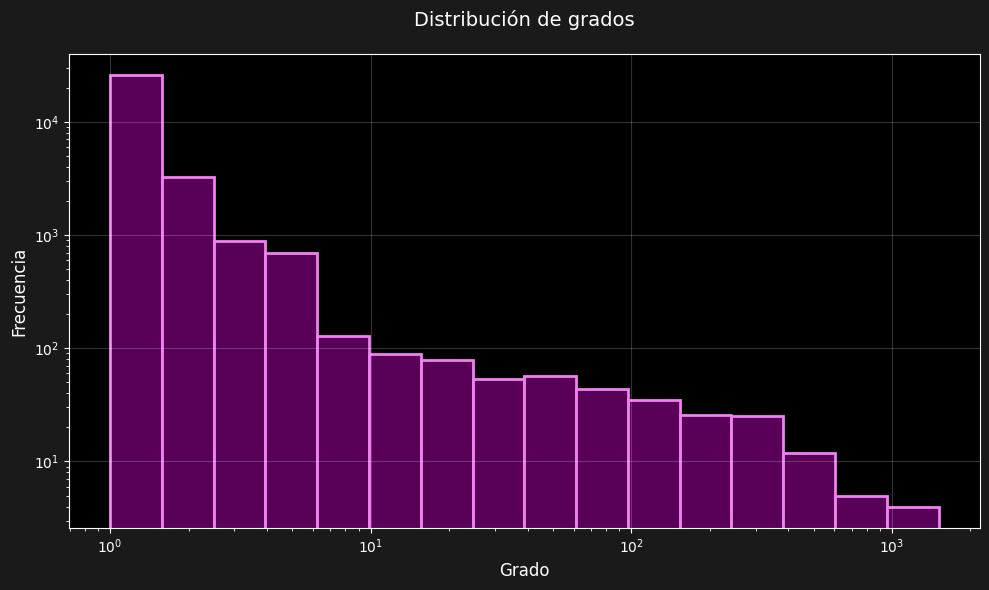

In [43]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
plt.style.use('dark_background')
sns.histplot(data=degrees, kde=False, color='purple', alpha=0.7,
             edgecolor='violet', log_scale=True, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1, 10, 100, 1000], color='white')
plt.yticks(color='white')
plt.title("Distribución de grados", color='white', size=14, pad=20)
plt.xlabel("Grado", color='white', size=12)
plt.ylabel("Frecuencia", color='white', size=12)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


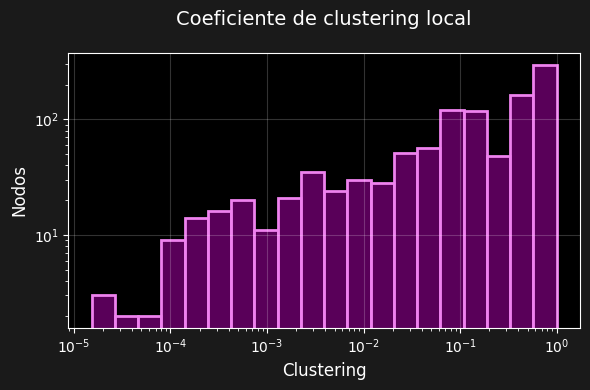

Clustering medio: 0.0124


In [44]:
clust_coef = nx.clustering(G)
df_clust = pd.Series(clust_coef, name='clustering')
plt.figure(figsize=(6, 4), facecolor='#1a1a1a')
plt.style.use('dark_background')
sns.histplot(df_clust, kde=False, edgecolor='violet', color='purple', alpha=0.7, log_scale=True, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.title("Coeficiente de clustering local", color='white', size=14, pad=20)
plt.xlabel("Clustering", color='white', size=12)
plt.ylabel("Nodos", color='white', size=12)
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Clustering medio: {df_clust.mean():.4f}")


#### Análisis de Clustering en nuestra red

El **coeficiente de clustering local** nos indica qué tan “cerrado” está el círculo de cada usuario: la probabilidad de que dos de sus contactos también interactúen entre sí.

- **0** → Ninguno de sus amigos se conoce.  
- **1** → Todos sus amigos están conectados entre sí.  
- **(0,1)** → Cohesión parcial: algunos vecinos sí se conocen.

---


##### Qué nos cuenta la red

1. **Usuarios “puente” (clustering bajo)**  
   - Muchos usuarios cerca de 0.  
   - Conectan comunidades distintas, pero sus contactos no se conocen entre sí.  
   - Son esenciales para difundir ideas de un grupo a otro.

2. **Comunidades cerradas (clustering alto)**  
   - Un grupo más pequeño, con coeficientes cerca de 1.  
   - Todos interactúan entre sí, formando núcleos muy sólidos.  
   - Promueven la viralidad interna: un rumor se propaga rápido dentro de ese círculo.

---

##### Conclusiones

- Como tenemos muchos usuarios con clustering bajo podemos afirmar que se trata de una **red abierta**, perfecta para un alcance masivo, como el que desearía Reddit, poca profundidad y mucha amplitud.  
- La existencia de núcleos densos señala subreddits con discusiones muy activas y alta viralidad local, nichos.   


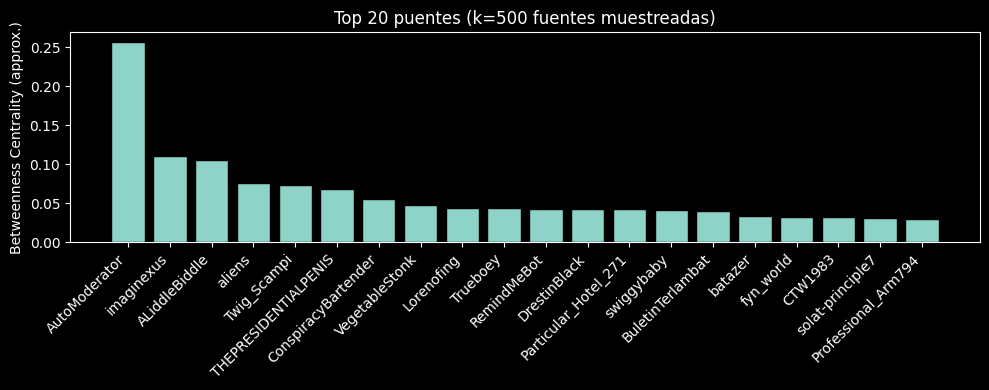

In [45]:
if not nx.is_connected(G):
    cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(cc).copy()


n = G.number_of_nodes()

k = min(500, n)
random.seed(42) 
bc = nx.betweenness_centrality(G, k=k, normalized=True, seed=42)

top20 = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:20]
nodes, scores = zip(*top20)

plt.figure(figsize=(10,4))
plt.bar([str(u) for u in nodes], scores, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Betweenness Centrality (approx.)')
plt.title(f'Top 20 puentes (k={k} fuentes muestreadas)')
plt.tight_layout()
plt.show()

#### Top 20 Puentes de Información (aproximación k=500)

Este análisis se realiza sobre una **muestra de 500 fuentes** de la red, usando betweenness centrality para identificar nodos clave.

**Betweenness centrality** revela qué usuarios sirven de “nexo” en las rutas más cortas de la red.

- En esta muestra aparecen numerosos usuarios con valores altos que conectan varias conspiraciones.
- Estos puentes aceleran la difusión, demostrando que las noticias circulan rápido entre comunidades que de otro modo estarían aisladas.

- **Alcance:** trabajar con estos nodos potencia la propagación de mensajes.  

In [46]:
cliques = list(nx.find_cliques(G))
print(f"Número total de cliques encontradas: {len(cliques)}")
max_clique_size = max(len(c) for c in cliques)
print(f"Tamaño de la clique máxima: {max_clique_size}")

Número total de cliques encontradas: 39097
Tamaño de la clique máxima: 5


### Significado de las cliques

- **Clique**: subgrupo de nodos donde cada par está conectado.  
- **39 113 cliques**: múltiples grupos cohesionados detectados.  
- **Tamaño máximo = 5**: el mayor núcleo completo engloba 5 usuarios.  
- **Interpretación**: existen numerosos pequeños “círculos cerrados” en la red, reflejando comunidades muy unidas.  


In [47]:
partition = community_louvain.best_partition(G)
mod = community_louvain.modularity(partition, G)
print(f"Comunidades detectadas: {len(set(partition.values()))}")
print(f"Modularidad (Louvain): {mod:.3f}")

AttributeError: module 'community' has no attribute 'best_partition'

### Qué indican las comunidades

- Son grupos de nodos muy conectados entre sí.  
- Detectamos **45 comunidades**, casi cinco veces más que los 10 subreddits originales, lo que revela subgrupos temáticos internos.  
- La **modularidad (0.814)** confirma que cada comunidad está fuertemente unida por dentro y casi no se comunica con las demás.   

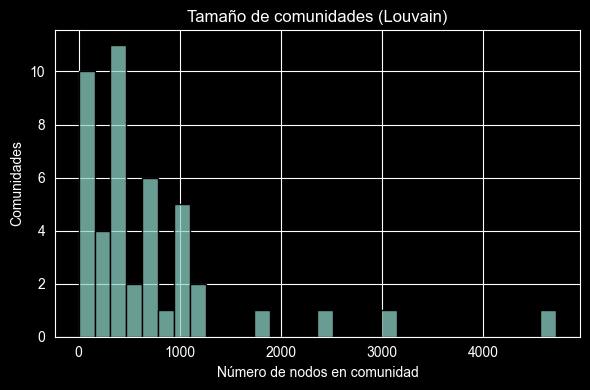

In [ ]:
# Histograma de tamaños de comunidad
com_sizes = pd.Series(list(partition.values())).value_counts()
plt.figure(figsize=(6,4))
sns.histplot(com_sizes, bins=30, kde=False, edgecolor='black')
plt.title("Tamaño de comunidades (Louvain)")
plt.xlabel("Número de nodos en comunidad")
plt.ylabel("Comunidades")
plt.tight_layout()
plt.show()

#### Comparativo de Comunidades Reddit

1. **Subgrafos por subreddit**  
   Extraemos nodos y aristas que comparten etiqueta `subreddit`.

2. **Cálculo de métricas**  
   Para cada subgrafo obtenemos:  
   - Tamaño (nodos)  
   - Conexiones (aristas)  
   - Grado promedio  
   - Densidad  
   - Clustering

3. **Visualización 2×2**  
   Barras para:  
   - Número de usuarios  
   - Grado promedio  
   - Densidad interna  
   - Coeficiente de clustering


*Para evitar warnings al usar seaborn incluimos esta celda, no relevante*

In [51]:
import warnings

warnings.filterwarnings("ignore")


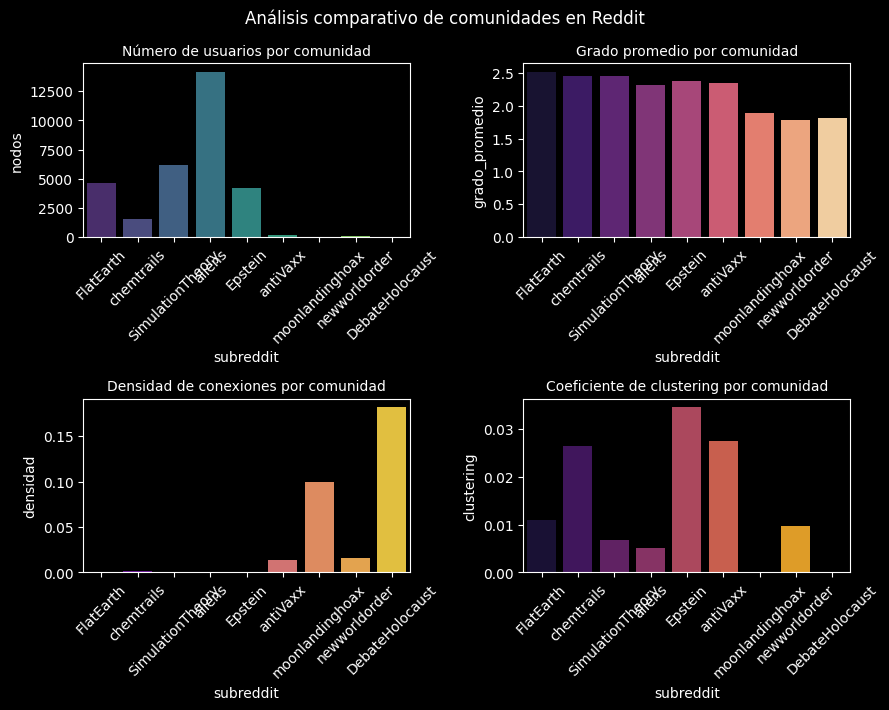

In [52]:
import seaborn as sns
import pandas as pd

subgrafos = {}

# subgrafos para cada subreddit
for nodo in grafo.nodes():
    subreddit = grafo.nodes[nodo].get('subreddit', None)
    if subreddit:
        if subreddit not in subgrafos:
            subgrafos[subreddit] = nx.Graph()
        subgrafos[subreddit].add_node(nodo)


for u, v in grafo.edges():
    subreddit_u = grafo.nodes[u].get('subreddit', None)
    subreddit_v = grafo.nodes[v].get('subreddit', None)
    if subreddit_u and subreddit_u == subreddit_v:
        subgrafos[subreddit_u].add_edge(u, v)

# DataFrame para almacenar las métricas de cada subreddit
metricas = []
for subreddit, subgrafo in subgrafos.items():
    grados = [d for _, d in subgrafo.degree()]
    metricas.append({
        'subreddit': subreddit,
        'nodos': subgrafo.number_of_nodes(),
        'aristas': subgrafo.number_of_edges(),
        'grado_promedio': sum(grados) / len(grados) if grados else 0,
        'densidad': nx.density(subgrafo),
        'clustering': nx.average_clustering(subgrafo)
    })

df_metricas = pd.DataFrame(metricas)

# varios subplots para las diferentes métricas
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(9, 7.2))  
fig.suptitle('Análisis comparativo de comunidades en Reddit', fontsize=12, y=0.98)  

# barras para el número de nodos
sns.barplot(data=df_metricas, x='subreddit', y='nodos', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Número de usuarios por comunidad', fontsize=10)  # Reduced from default
axes[0, 0].tick_params(axis='x', rotation=45)

# barras para el grado promedio
sns.barplot(data=df_metricas, x='subreddit', y='grado_promedio', ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Grado promedio por comunidad', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)

# barras para la densidad
sns.barplot(data=df_metricas, x='subreddit', y='densidad', ax=axes[1, 0], palette='plasma')
axes[1, 0].set_title('Densidad de conexiones por comunidad', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=45)

# barras para el clustering
sns.barplot(data=df_metricas, x='subreddit', y='clustering', ax=axes[1, 1], palette='inferno')
axes[1, 1].set_title('Coeficiente de clustering por comunidad', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Heatmap de solapamiento

Calcularemos un heatmap con el número de usuarios compartidos entre cada par de comunidades.  
Esto nos permitirá:

- Destacar solapamientos clave.  
- Justificar la cercanía de los nodos en el grafo.  

In [53]:
conexiones_entre_subreddits = []
for u, v in grafo.edges():
    subreddit_u = grafo.nodes[u].get('subreddit', None)
    subreddit_v = grafo.nodes[v].get('subreddit', None)

    if subreddit_u and subreddit_v and subreddit_u != subreddit_v:
        conexiones_entre_subreddits.append((subreddit_u, subreddit_v))

# Crear DataFrame con las conexiones
df_conexiones = pd.DataFrame(conexiones_entre_subreddits, columns=['subreddit1', 'subreddit2'])

# Contar frecuencias de conexiones
conexiones_count = df_conexiones.groupby(['subreddit1', 'subreddit2']).size().reset_index(name='count')
conexiones_count = conexiones_count.sort_values('count', ascending=False)

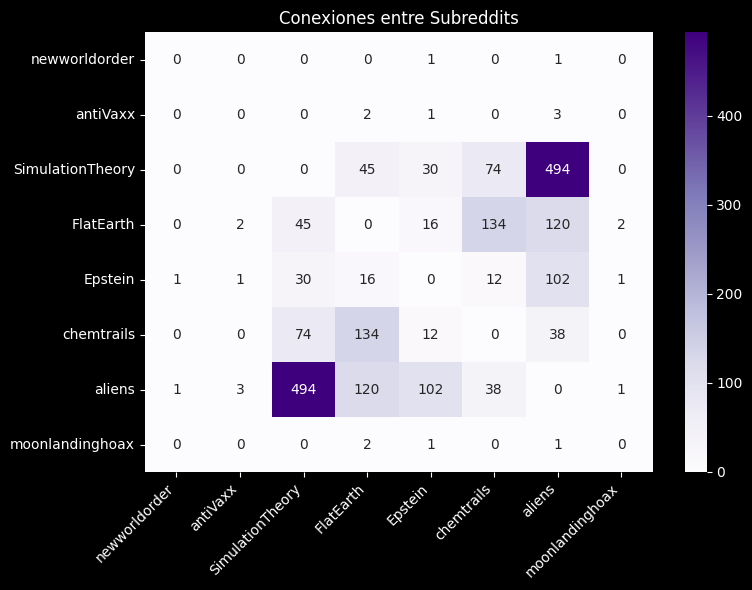

In [54]:
# matriz de adyacencia para el heatmap
subreddits_unicos = list(set(conexiones_count['subreddit1'].unique()) | set(conexiones_count['subreddit2'].unique()))
matriz_adj = pd.DataFrame(0, index=subreddits_unicos, columns=subreddits_unicos)

for _, row in conexiones_count.iterrows():
    matriz_adj.loc[row['subreddit1'], row['subreddit2']] = row['count']
    matriz_adj.loc[row['subreddit2'], row['subreddit1']] = row['count']

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_adj, annot=True, cmap='Purples', fmt='.0f')
plt.title('Conexiones entre Subreddits')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [55]:
print("\nTop 20 conexiones más fuertes entre subreddits:")
print(conexiones_count.head(20))


Top 20 conexiones más fuertes entre subreddits:
          subreddit1        subreddit2  count
13  SimulationTheory            aliens    910
17            aliens  SimulationTheory    494
16            aliens         FlatEarth    419
24        chemtrails         FlatEarth    144
2            Epstein            aliens    139
10         FlatEarth        chemtrails    134
8          FlatEarth            aliens    120
14  SimulationTheory        chemtrails    114
15            aliens           Epstein    102
1            Epstein  SimulationTheory     95
25        chemtrails  SimulationTheory     74
7          FlatEarth  SimulationTheory     56
19            aliens        chemtrails     50
12  SimulationTheory         FlatEarth     45
6          FlatEarth           Epstein     43
26        chemtrails            aliens     38
11  SimulationTheory           Epstein     30
0            Epstein         FlatEarth     16
23        chemtrails           Epstein     13
4            Epstein        che

### Características Principales del Grafo

| Métrica | Valor |
|---------|-------|
| Número de Nodos | 31,116 |
| Número de Aristas | 40,704 |
| Densidad | 0.000084 |
| Grado Promedio | 2.62 |
| Coeficiente de Clustering Promedio | 0.017 |
| Número de Comunidades | 41 |
| Modularidad | 0.814 |
| Componentes Conectados | múltiples |

#### Observaciones Principales

1. **Estructura General**:
   - El grafo es disperso (densidad muy baja)
   - Presenta una estructura de comunidades bien definida (alta modularidad)
   - El grado promedio indica que cada usuario interactúa con ~2-3 otros usuarios

2. **Comunidades**:
   - Se identificaron 45 comunidades distintas
   - La modularidad de 0.814 indica una fuerte estructura comunitaria y de nicho.

3. **Conectividad**:
   - El grafo no es completamente conexo
   - Los subreddits muestran diferentes patrones de conexión entre sí

4. **Clustering**:
   - El bajo coeficiente de clustering (0.017) sugiere poca tendencia a formar grupos cerrados
   - Varía significativamente entre diferentes subreddits
